In [24]:
#imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
#image directory
directory = "/content/"

In [25]:
checkerboard_path = directory + "checkerboard.png"
courthouse_path = directory + "courthouse_gray.jpg"
img1_path = directory + "IMG_1949.JPG"
img2_path = directory + "IMG_1950.JPG"
panorama1_path = directory + "part1.png"
panorama2_path = directory + "part2.png"
panorama3_path = directory + "part3.png"

In [26]:
def resize_image(img, target_size=None, scale_factor=None):
    height, width = img.shape[:2]
    if(scale_factor == None and target_size == None):
        return img
    elif(scale_factor == None and target_size != None):
        larger_dimension = max(height, width)
        scale_factor = target_size / larger_dimension
        resized_img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))
    else:
        resized_img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))

    return resized_img

def rotate_image(img, rotation=0):
    height, width = img.shape[0:2]
    M = cv2.getRotationMatrix2D((width/2,height/2), rotation, 1.2)
    img_rotated = cv2.warpAffine(img, M, (width,height))

    return img_rotated

# Harris Corner Detection

In [27]:
# Used https://www.geekering.com/programming-languages/python/brunorsilva/harris-corner-detector-python/
# for trouble shoot and compare my implementation

def harris_corner_detection(img_path, window_size, threshold):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = resize_image(img, target_size=500)

    #Optional Blur
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    #1: Compute the image derivatives
    dx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=5)

    #2: Compute the square of the derivatives.
    dx_square = dx * dx
    dy_square = dy * dy
    dx_dy = dx * dy

    #3: Apply Gaussian Filtering on the output of Step 2.
    dx_square_blur = cv2.GaussianBlur(dx_square, (5, 5), 0)
    dy_square_blur = cv2.GaussianBlur(dy_square, (5, 5), 0)
    dx_dy_blur = cv2.GaussianBlur(dx_dy, (5, 5), 0)

    #4: Compute the cornerness function response: Determinant(H) − kTrace(H)^2), where k=0.05.
    k = 0.05
    determinant = (dx_square_blur * dy_square_blur) - (dx_square_blur*dx_square_blur)
    kTrace = dx_square_blur + dy_square_blur
    response = determinant - (k*(kTrace**2))

    #5: Perform non-maximum suppression
    offset = window_size // 2
    corner_points = []

    for i in range(offset, response.shape[0] - offset):
        for j in range(offset, response.shape[1] - offset):
            window = response[i-offset:i+1+offset, j-offset:j+1+offset]
            center_value = window[offset, offset]
            if center_value > threshold and center_value == np.max(window):
                corner_points.append((j, i))

    return corner_points

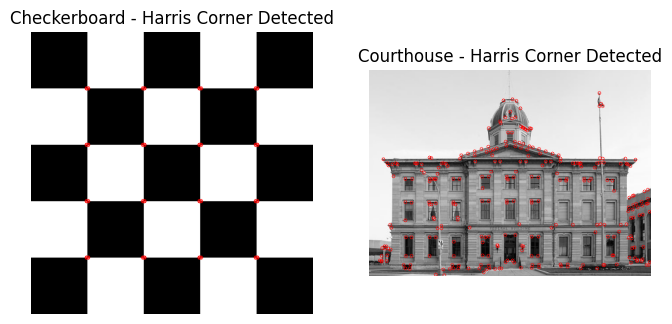

In [28]:
checkerboard_corners = harris_corner_detection(checkerboard_path, 3, 1)
checkerboard = cv2.imread(checkerboard_path)
checkerboard = resize_image(checkerboard, target_size=500)

for o in checkerboard_corners:
    cv2.circle(checkerboard,(o[0],o[1]),3,(255,0,0))

courthouse_corners = harris_corner_detection(courthouse_path, 3, 999999999999)
courthouse = cv2.imread(courthouse_path)
courthouse = resize_image(courthouse, target_size=500)

for o in courthouse_corners:
    cv2.circle(courthouse,(o[0],o[1]),3,(255,0,0))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(checkerboard)
plt.title("Checkerboard - Harris Corner Detected")

plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(courthouse)
plt.title("Courthouse - Harris Corner Detected")
plt.axis("off")
plt.show()

#SIFT Features

###SIFT in a nutshell

### Briefly describe the 4 main actions/steps of the SIFT method.
### Information grabbed from ECSE 415 lecture 6

**Step 1: Generate a Scale-Space Image Pyramid**


*   Make a "Guassian" Pyramid: each layer is made by filtering the image with a Gaussian filter
*   Create a "Laplacian" Pyramid: subtracting one layer from the layer below it in Gaussian Pyramid using: $$L_i = G_i - expand(G_{i+1})$$




**Steps 2: SIFT key localization (feature detection)**


*   Detect the maxima and minima of difference of Gaussian images in scale space. This is done by iterating through each pixel and it's neighbouring pixels including the adjacent images.



**Steps 3: Eliminate unstable (noisy) keypoints**


*   Discard low contrast keypoints (identified as having a maximum difference of Gaussian value below a threshold)
*   Has a very similar approach to the Harris Corner Detector



**Step 4: Select a canonical orientation for the SIFT keypoint**


*   Collect gradient directions and magnitudesa around each keypoint to determine the most prominent orientation(s) in that region, then assign this orientation to the keypoint
*   Look at a neighborhood of the keypoint that is 1.5 times the selected scale. Then, create a gaussian weighted historgram of local gradient directions. The amount added to each bin is proportional to the magnitude of gradient at that point
*   Identify peaks in the histogram above 80% of the highest peak. Convert these peaks into new keypoints, retaining the original location and scale, but assigning the orientation corresponding to the peak



### SIFT between two different pictures

In [29]:
#Looked at https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html for reference
#Used at ECSE 415 Tutorial 4 Code for reference

def SIFT_two_pics(img1, img2):
    #1: Compute SIFT keypoints for image_1 and image_2.
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    #2: Match all keypoints between two images using a brute-force method.
    bf = cv2.BFMatcher()
    matches = bf.match(descriptors1, descriptors2)

    #3: Sort the matching keypoints according to the matching distance.
    matches_sorted = sorted(matches, key = lambda x:x.distance)

    #4: Display the top ten matched keypoints.
    top_10 = matches_sorted[:10]
    matched_image = cv2.drawMatches(img1, keypoints1, img2, keypoints2, top_10, None, matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title('Top Ten Matched Keypoints')
    plt.axis('off')
    plt.show()

    #5: Plot the matching distance for the top 100 matched keypoints. Plot the indices of keypoints on the x-axis and the corresponding matching distance on the y-axis.
    top_100_distances = [match.distance for match in matches_sorted[:100]]

    plt.plot(range(len(top_100_distances)), top_100_distances)
    plt.xlabel('Indices of Keypoints')
    plt.ylabel('Matching Distance')
    plt.title('Matching Distance for Top 100 Matched Keypoints')
    plt.show()


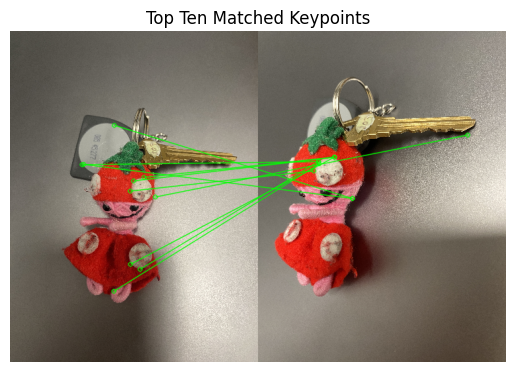

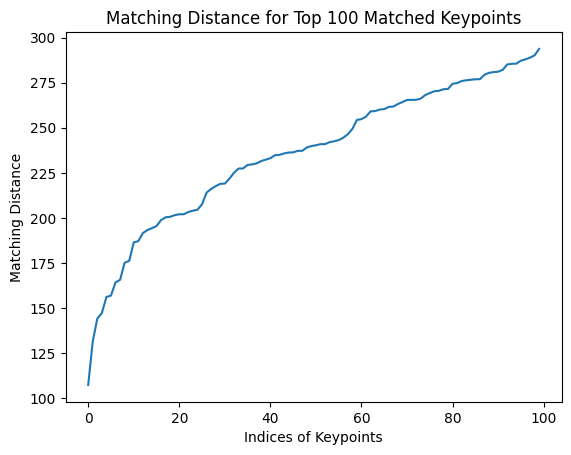

In [30]:
img1 = cv2.imread(img1_path, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(img2_path, cv2.COLOR_BGR2RGB)
img1_resized = resize_image(img1, target_size=500)
img2_resized = resize_image(img2, target_size=500)
SIFT_two_pics(img1_resized, img2_resized)

###Invariance Under Scale

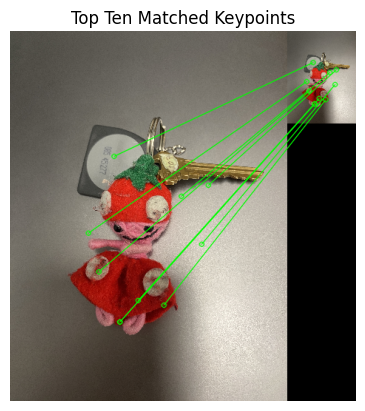

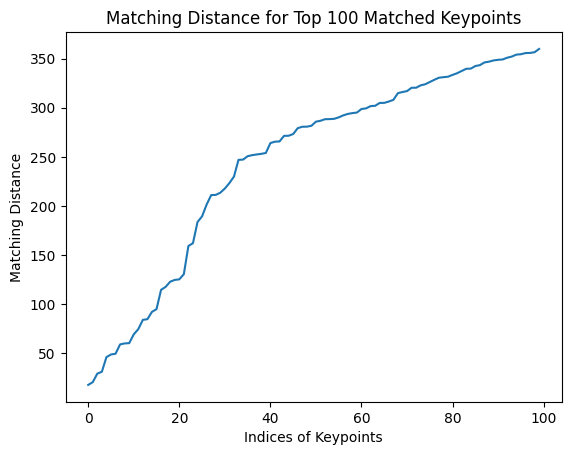

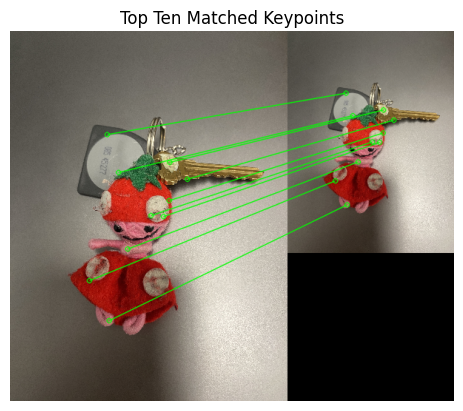

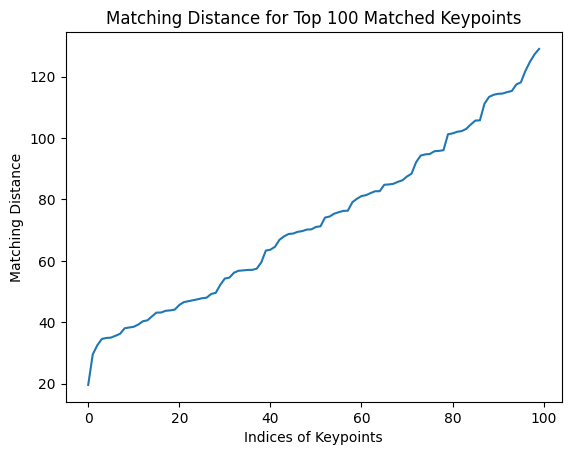

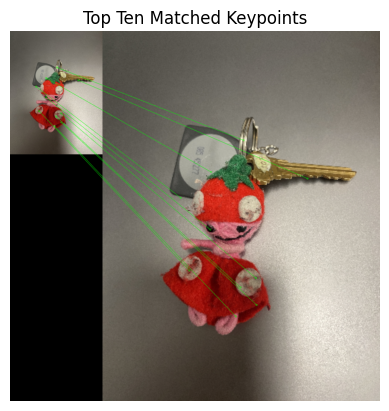

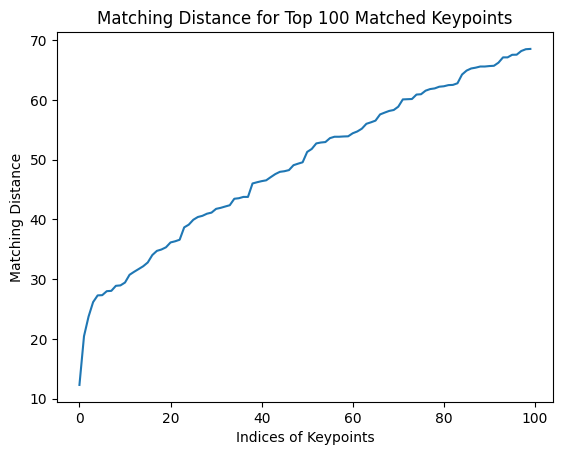

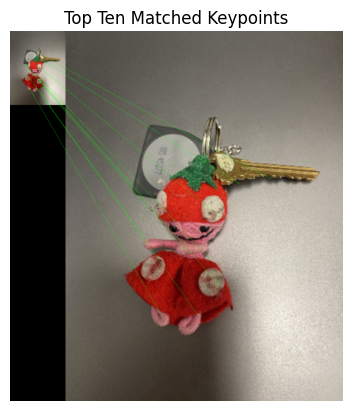

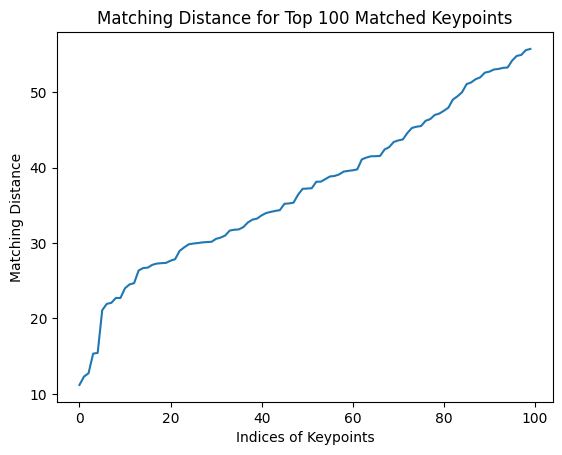

In [31]:
img1 = cv2.imread(img1_path, cv2.COLOR_BGR2RGB)
img1_resized = resize_image(img1, target_size=500)

img1_s025 = resize_image(img1_resized, scale_factor=0.25)
img1_s06 = resize_image(img1_resized, scale_factor=0.6)
img1_s3 = resize_image(img1_resized, scale_factor=3)
img1_s5 = resize_image(img1_resized, scale_factor=5)

SIFT_two_pics(img1_resized, img1_s025)
SIFT_two_pics(img1_resized, img1_s06)
SIFT_two_pics(img1_resized, img1_s3)
SIFT_two_pics(img1_resized, img1_s5)

### Discussion: Plotted results' trend and the effect of increasing the scale on the matching distance

As the scale factor increases, the matching distance decreases (as seen on the Y-axis scales). This indicates a higher similarity between keypoints between the original image and the scaled images. Therefore, concluding that a higher scaling factor improves matching accuracy.

###Invariance Under Rotation

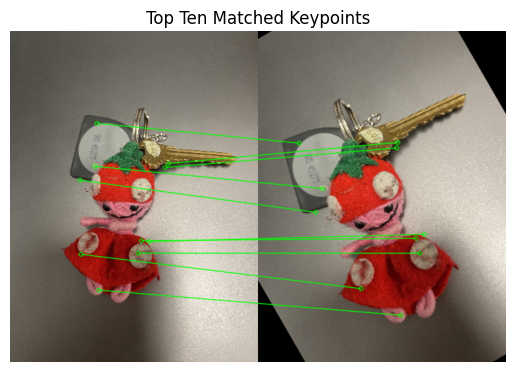

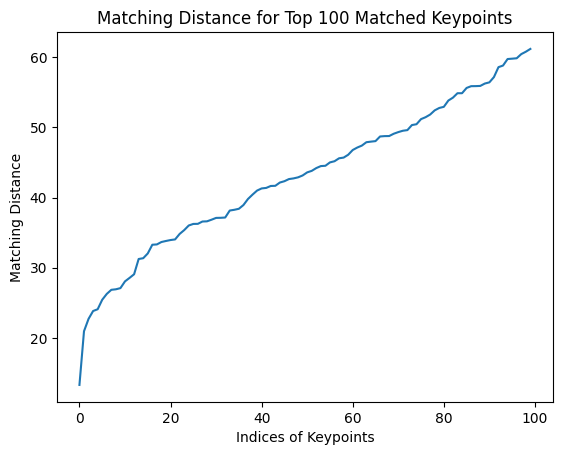

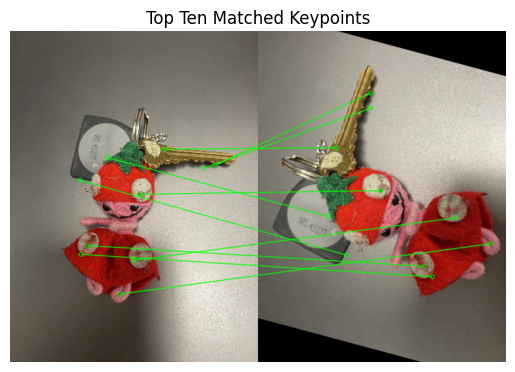

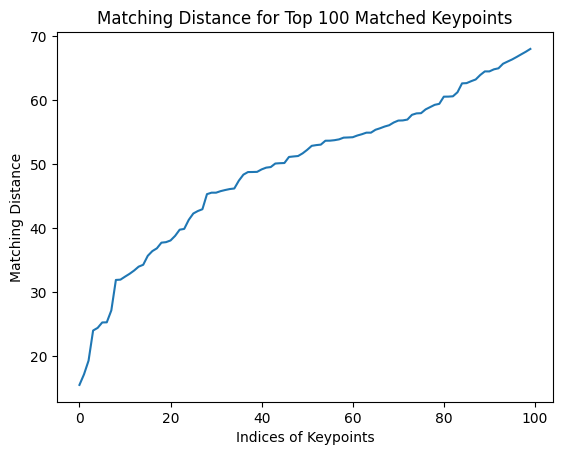

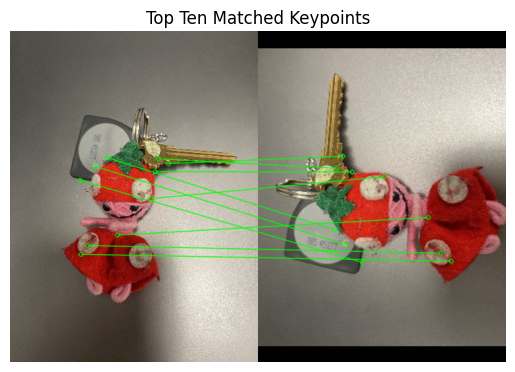

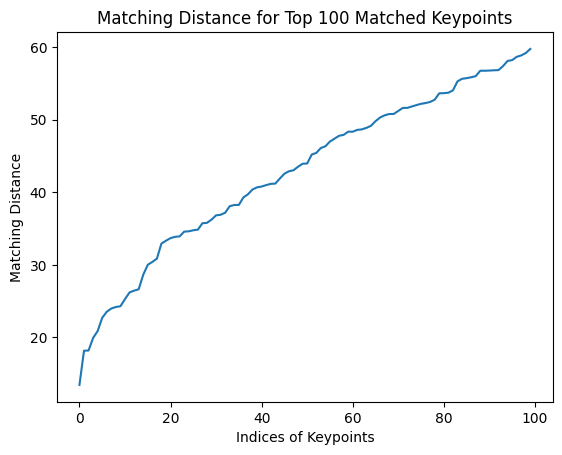

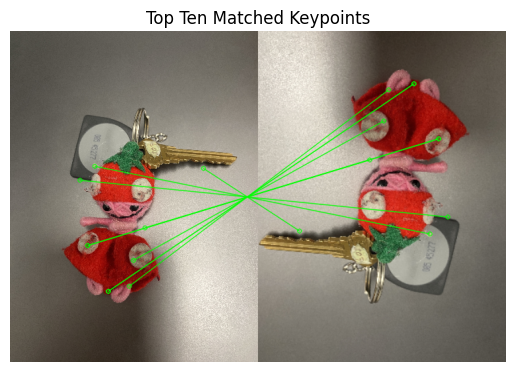

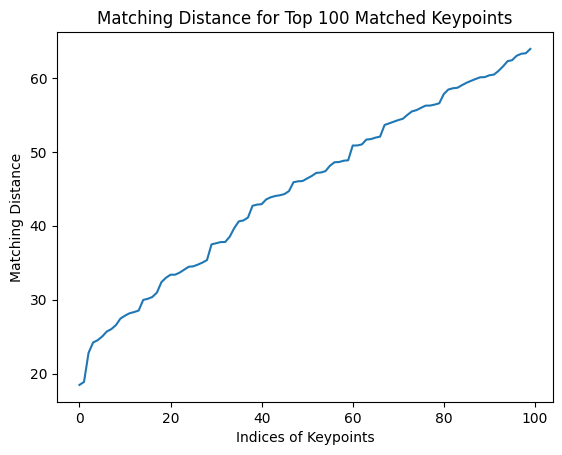

In [33]:
img1 = cv2.imread(img1_path, cv2.COLOR_BGR2RGB)
img1_resized = resize_image(img1, target_size=500)

img1_r30 = rotate_image(img1_resized, 30)
img1_r75 = rotate_image(img1_resized, 75)
img1_r90 = rotate_image(img1_resized, 90)
img1_r180 = rotate_image(img1_resized, 180)

SIFT_two_pics(img1_resized, img1_r30)
SIFT_two_pics(img1_resized, img1_r75)
SIFT_two_pics(img1_resized, img1_r90)
SIFT_two_pics(img1_resized, img1_r180)

### Discussion: Plotted results' trend and the effect of increasing the angle of rotation on the matching distance

The plotted results don't show a clear trend, likely because the object remained fully visible without being cut off. The cut off portion was only the background, which didn't significantly affect the keypoints and matching distance, given its monochromatic nature.

In theory, if the object were cut off due to rotation, match accuracy could decrease for rotations between (0,180) and (180,360) degrees as some keypoints might be lost. However, a rotation of 180 degrees would behave similarly to rotations of 0 and 360 degrees since none of the image content would be lost, only inverted

#Image Stitching

In [34]:
#Used Tutorial 4 for reference
#Used https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html for linear blending

def image_stitching(img1, img2):
    #a & e: Compute the SIFT keypoints and corresponding descriptors for images 1 and 2.
    sift = cv2.xfeatures2d.SIFT_create()

    keypoint1, descriptor1 = sift.detectAndCompute(img1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(img2, None)

    #b & f: Find matching keypoints in images 1 and 2 and display the 20 best pairs.
    bf = cv2.BFMatcher()
    matches = bf.match(descriptor1, descriptor2)
    matches_sorted = sorted(matches, key=lambda x: x.distance)

    top_20 = matches_sorted[:20]
    img_matches = cv2.drawMatches(img1, keypoint1, img2, keypoint2, top_20, None,
                                  matchColor=(0, 255, 0), singlePointColor=(255, 0, 0),
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches between Image 1 and Image 2')
    plt.axis('off')
    plt.show()

    """
    c & g: Find the homography that best matches the keypoints from image 1 and 2 using the
    RANSAC method, and apply the resulting transformation to image 1. Image 2 should
    not be transformed.
    """
    good_matches = [m for m in matches_sorted if m.distance < 1000]

    mp1 = np.float32([keypoint1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    mp2 = np.float32([keypoint2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(mp2, mp1, cv2.RANSAC)

    overlap_width = int(img1.shape[1] - H[0, 2])

    #Combining a little bit less than the actual overlap, so that it can blend the last little bit in next step
    residual_overlap = int(H[0, 2]/5)
    H[0, 2] += residual_overlap
    transformed_img = cv2.warpPerspective(img2, H, (img2.shape[1]+img1.shape[1]-(overlap_width-residual_overlap),img2.shape[0]))
    transformed_img[:, 0:img1.shape[1]-(overlap_width-residual_overlap)] = img1[:, 0:img1.shape[1]-(overlap_width-residual_overlap)]

    #Shows the transformed image, with slight repetition at stitch point, to ensure that blending goes well
    #Commented out as it is not required as per the assignment instruction
    # plt.figure(figsize=(12, 4))
    # plt.imshow(cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))
    # plt.title("Panoramic Image")
    # plt.axis('off')
    # plt.show()

    """
    d & h: Stitch the transformed image 1 and the original image 2 together using linear image
    blending. Let us call this image 12. Display this image.
    """
    opacity = 0.5
    middleStitch = transformed_img.shape[1] - img2.shape[1]
    imgA = transformed_img[:, :middleStitch]
    imgB = transformed_img[:, middleStitch:]

    blend_region = cv2.addWeighted(imgA[:, imgA.shape[1] - residual_overlap:], opacity, imgB[:, :residual_overlap], 1-opacity, 0)
    blended_image = cv2.hconcat([imgA[:, :imgA.shape[1] - residual_overlap], blend_region, imgB[:, residual_overlap:]])

    # Display the stitched image
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
    plt.title("Stitched Image")
    plt.axis('off')
    plt.show()

    return blended_image


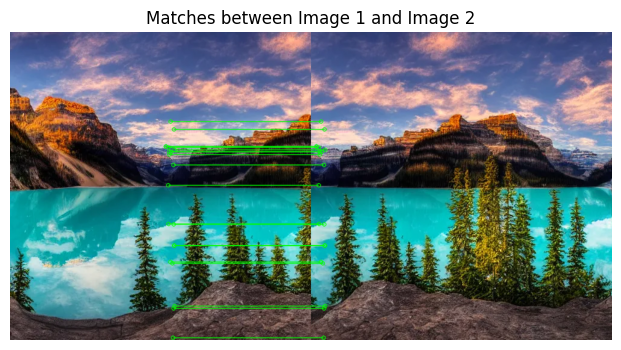

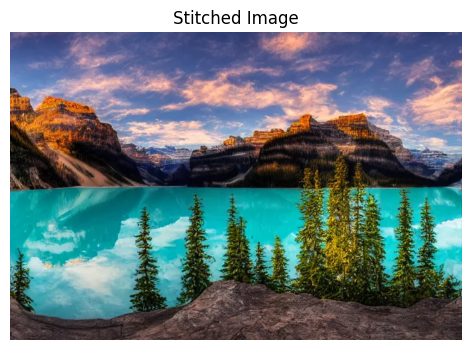

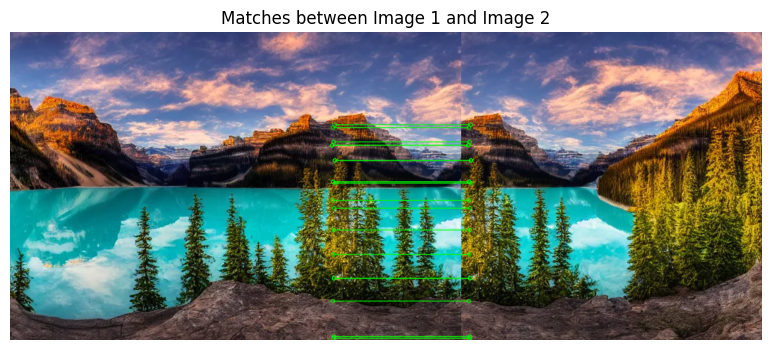

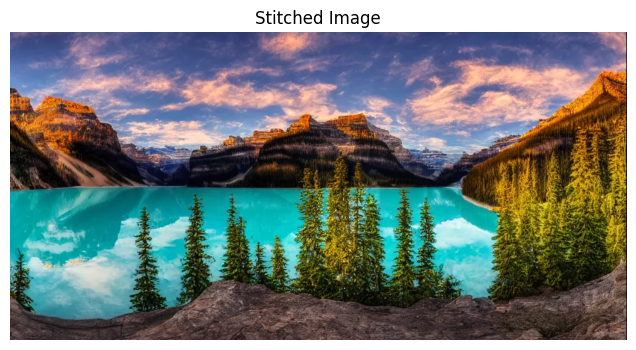

In [35]:
image12 = image_stitching(cv2.imread(panorama1_path), cv2.imread(panorama2_path))
image123 = image_stitching(image12, cv2.imread(panorama3_path))

###Discussion: Pyramid Blending vs Linear Blending

*Used ECSE415 Lecture 7 for reference*

Linear Blending is overall and easier process than Pyramid Blending as it requires to just smooth the pixels at the stitching point between two images Especially for 2 images that has a perfect fit, a user would not be able to tell the difference between a linear blend and a pyramid blend. However, if the images are not perfelctly aligned, pyramid blending provides a balance between smoothing low frequency exposure variations while retaining sharp transition.